In [1]:
import os
import glob
import time
from datetime import datetime

import torch
import numpy as np

import gym
import gym_rbdl
# import roboschool

# import pybullet_envs

from PPO import PPO

Device set to : cpu


training environment name : jbdl_half_cheetah-v0
CURRENT_PATH /Users/xieguo/Projects/differentiable_engines/tmp/private/magics_sim_private
MODEL_DATA_PATH /Users/xieguo/Projects/differentiable_engines/tmp/private/magics_sim_private/envs/model_data
current logging run number for jbdl_half_cheetah-v0 :  1
logging at : PPO_logs_forward_reward_joint_limit/jbdl_half_cheetah-v0//PPO_jbdl_half_cheetah-v0_log_1.csv
save checkpoint path : PPO_preTrained_forward_reward_joint_limit/jbdl_half_cheetah-v0/PPO_jbdl_half_cheetah-v0_0_0.pth
--------------------------------------------------------------------------------------------
max training timesteps :  3000000
max timesteps per episode :  500
model saving frequency : 100000 timesteps
log frequency : 1000 timesteps
printing average reward over episodes in last : 5000 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  14
action space dimension :  4
-------------------------

/Users/xieguo/miniconda3/envs/jaxrbdl/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


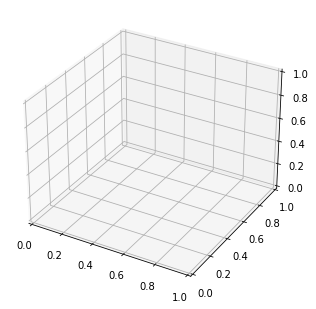

In [7]:
print("============================================================================================")


####### initialize environment hyperparameters ######

# env_name = "RoboschoolHalfCheetah-v1"
# env_name = "jbdl_half_cheetah-v0"
env_name = "jbdl_half_cheetah-v0"

has_continuous_action_space = True  # continuous action space; else discrete

# max_ep_len = 1000                   # max timesteps in one episode
max_ep_len = 500 
max_training_timesteps = int(3e6)   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 10        # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2           # log avg reward in the interval (in num timesteps)
save_model_freq = int(1e5)          # save model frequency (in num timesteps)

action_std = 0.6                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(2.5e5)  # action_std decay frequency (in num timesteps)

#####################################################


## Note : print/log frequencies should be > than max_ep_len


################ PPO hyperparameters ################

update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 80               # update policy for K epochs in one PPO update

eps_clip = 0.2          # clip parameter for PPO
gamma = 0.99            # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

#####################################################



print("training environment name : " + env_name)

env = gym.make(env_name)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n



###################### logging ######################

#### log files for multiple runs are NOT overwritten

log_dir = "PPO_logs_forward_reward_joint_limit"
if not os.path.exists(log_dir):
      os.makedirs(log_dir)

log_dir = log_dir + '/' + env_name + '/'
if not os.path.exists(log_dir):
      os.makedirs(log_dir)


#### get number of log files in log directory
run_num = 0
current_num_files = next(os.walk(log_dir))[2]
run_num = len(current_num_files)


#### create new log file for each run
log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

print("current logging run number for " + env_name + " : ", run_num)
print("logging at : " + log_f_name)

#####################################################


################### checkpointing ###################

run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder

directory = "PPO_preTrained_forward_reward_joint_limit"
if not os.path.exists(directory):
      os.makedirs(directory)

directory = directory + '/' + env_name + '/'
if not os.path.exists(directory):
      os.makedirs(directory)


checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("save checkpoint path : " + checkpoint_path)

#####################################################


############# print all hyperparameters #############

print("--------------------------------------------------------------------------------------------")

print("max training timesteps : ", max_training_timesteps)
print("max timesteps per episode : ", max_ep_len)

print("model saving frequency : " + str(save_model_freq) + " timesteps")
print("log frequency : " + str(log_freq) + " timesteps")
print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")

print("--------------------------------------------------------------------------------------------")

print("state space dimension : ", state_dim)
print("action space dimension : ", action_dim)

print("--------------------------------------------------------------------------------------------")

if has_continuous_action_space:
    print("Initializing a continuous action space policy")
    print("--------------------------------------------------------------------------------------------")
    print("starting std of action distribution : ", action_std)
    print("decay rate of std of action distribution : ", action_std_decay_rate)
    print("minimum std of action distribution : ", min_action_std)
    print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")

else:
    print("Initializing a discrete action space policy")

print("--------------------------------------------------------------------------------------------")

print("PPO update frequency : " + str(update_timestep) + " timesteps")
print("PPO K epochs : ", K_epochs)
print("PPO epsilon clip : ", eps_clip)
print("discount factor (gamma) : ", gamma)

print("--------------------------------------------------------------------------------------------")

print("optimizer learning rate actor : ", lr_actor)
print("optimizer learning rate critic : ", lr_critic)

if random_seed:
    print("--------------------------------------------------------------------------------------------")
    print("setting random seed to ", random_seed)
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)

#####################################################

print("============================================================================================")

################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")


# logging file
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')


# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0

In [8]:
while time_step <= max_training_timesteps:

    state = env.reset()
    current_ep_reward = 0

    for t in range(1, max_ep_len+1):

        # select action with policy
        action = ppo_agent.select_action(state)
#         action.clip 
        state, reward, done, _ = env.step(action)
        # print("action",action)
        # print("state",state)
        # env.plt_render()
        # print("action",type(action))
        # print("state",state)
        # print("reward",type(reward))

        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        # log in logging file
        if time_step % log_freq == 0:

            # log average reward till last episode
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)

            log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            log_f.flush()

            log_running_reward = 0
            log_running_episodes = 0

        # printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)

            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

            print_running_reward = 0
            print_running_episodes = 0

        # save model weights
        if time_step % save_model_freq == 0:
            print("--------------------------------------------------------------------------------------------")
            print("saving model at : " + checkpoint_path)
            ppo_agent.save(checkpoint_path)
            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")

        # break; if the episode is over
        if done:
            break

    print_running_reward += current_ep_reward
    print_running_episodes += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    i_episode += 1


log_f.close()
env.close()

u [-0.37326738 -0.03185535 -1.3598198   0.60600066]
next_xk [ 1.99999973e-01  4.99989122e-01  2.98347527e-06  5.23655891e-01
 -5.23626566e-01 -1.04744554e+00  1.04730022e+00 -5.16093023e-05
 -2.17468422e-02  5.96729852e-03  1.14243716e-01 -5.55480197e-02
 -4.95837331e-01  2.05276832e-01]
u [ 0.32270712 -0.52024335 -0.6237216  -0.48309296]
next_xk [ 1.9999996e-01  4.9993557e-01  1.9582838e-05  5.2392501e-01
 -5.2373415e-01 -1.0485781e+00  1.0476470e+00  1.0820885e-04
 -4.1821811e-02  1.5298614e-02  1.9543548e-01 -4.8534654e-02
 -7.7779323e-01  7.7689916e-02]
u [-0.6737695   0.39442617  0.1230309  -0.03011653]
next_xk [ 2.0000008e-01  4.9984246e-01  5.0282357e-05  5.2428597e-01
 -5.2382028e-01 -1.0500746e+00  1.0477803e+00 -8.7206354e-05
 -6.0740892e-02  1.5502335e-02  1.3568465e-01 -2.6731458e-02
 -6.5940523e-01  3.3360906e-02]
u [ 0.05395293 -0.5465528  -0.42548925 -0.02857736]
next_xk [ 1.9999979e-01  4.9971083e-01  8.3571853e-05  5.2457982e-01
 -5.2388775e-01 -1.0514810e+00  1.047862

next_xk [ 0.19985971  0.4775238  -0.00190651  0.511006   -0.538276   -1.0069122
  1.1102371  -0.00284784 -0.6684551  -0.02800901 -0.2827449  -0.22509788
  0.8007224   0.9496916 ]
u [-1.1851622  -0.00875026  0.368108    0.9021409 ]
next_xk [ 0.19985348  0.47617695 -0.00196638  0.5103818  -0.5387587  -1.0051734
  1.1122842  -0.00392878 -0.6883048  -0.03571897 -0.4001227  -0.289882
  1.0755818   1.2448373 ]
u [-0.43442988 -0.2903925  -0.01565592  0.02518183]
next_xk [ 0.19984539  0.4747905  -0.00203698  0.5095665  -0.53934693 -1.0030031
  1.1147864  -0.00439441 -0.7079074  -0.03404304 -0.43034717 -0.30687305
  1.1138458   1.2700379 ]
u [-0.02496612 -0.54979944  0.27928495 -1.5472329 ]
next_xk [ 0.19983655  0.47336596 -0.00209855  0.5086843  -0.5399187  -1.0007212
  1.1170874  -0.00447802 -0.725403   -0.02100801 -0.47341812 -0.22317667
  1.222221    0.79210705]
u [-0.37434447  0.7093544   0.94863343 -0.02725772]
next_xk [ 0.19982757  0.47190616 -0.0021443   0.50767475 -0.540344   -0.998063

u [-0.5723045 -0.0982497 -0.8326098 -0.5121167]
next_xk [ 1.9988127e-01  4.0265957e-01 -1.0135125e-02  6.0214353e-01
 -5.4489434e-01 -1.1191831e+00  1.1689543e+00  7.2516766e-03
 -1.3541474e+00 -3.0499905e-01  6.2197876e+00 -1.6090794e-01
 -1.0625214e+01  1.5926528e+00]
u [ 0.25863588  0.51773477 -0.9088902  -0.5874338 ]
next_xk [ 1.9989598e-01  3.9994112e-01 -1.0738050e-02  6.1462259e-01
 -5.4518789e-01 -1.1405733e+00  1.1720250e+00  7.6537146e-03
 -1.3744553e+00 -2.9082444e-01  6.2980652e+00 -1.0452617e-01
 -1.0902669e+01  1.3637972e+00]
u [-0.341505   -0.33488184  0.3905669   1.3884557 ]
next_xk [ 1.9991070e-01  3.9718139e-01 -1.1324801e-02  6.2718195e-01
 -5.4545307e-01 -1.1622431e+00  1.1749877e+00 -5.3891838e-03
 -1.3697497e+00 -1.2753960e-01  6.0357833e+00 -5.7119370e+00
 -1.0679512e+01  1.0671103e+01]
u [ 0.20562756 -1.251678    1.0409684   0.29130253]
next_xk [ 1.9989951e-01  3.9443138e-01 -1.1585174e-02  6.3920593e-01
 -5.5690652e-01 -1.1833780e+00  1.1963779e+00 -6.1815926e-

next_xk [ 1.9958980e-01  2.9653135e-01 -2.2429038e-02  1.0105308e+00
 -9.0445143e-01 -1.5707964e+00  1.5707964e+00 -4.3162042e-03
 -2.0044274e+00 -2.8132811e-01  7.7333179e+00 -7.2879891e+00
 -1.1519782e+01  1.2426319e+01]
u [-0.7799032   0.2393571  -0.46337658  0.20087826]
next_xk [ 1.99581236e-01  2.92511880e-01 -2.29922961e-02  1.02601898e+00
 -9.19037580e-01 -1.57079637e+00  1.57079637e+00 -4.17920761e-03
 -2.02564955e+00 -2.82522678e-01  7.77693558e+00 -7.30913925e+00
 -1.15165205e+01  1.24062510e+01]
u [-0.05474123 -0.8836665  -1.1705095   0.33329847]
next_xk [ 1.9957274e-01  2.8844887e-01 -2.3555534e-02  1.0416176e+00
 -9.3368435e-01 -1.5707964e+00  1.5707964e+00 -4.4647143e-03
 -2.0490625e+00 -2.7891338e-01  7.8658519e+00 -7.3662620e+00
 -1.1752234e+01  1.2413034e+01]
u [-0.8926752  -0.39638364 -0.02358528 -0.0625724 ]
next_xk [ 1.9956376e-01  2.8434089e-01 -2.4113491e-02  1.0471976e+00
 -9.4892412e-01 -1.5707964e+00  1.5707964e+00 -4.5642816e-03
 -2.0694072e+00 -2.7990168e-01 

u [-0.20723931 -0.6889372   0.2818024   0.13205612]
next_xk [  0.20020236   0.11812329  -0.04924934   1.0471976   -1.0471976
  -1.5707964    1.5707964    0.03065998  -2.8426688   -0.4697131
  11.345284   -11.6820135  -16.039984    16.898365  ]
u [ 1.996359   -1.3778762   0.04701301  0.12900452]
next_xk [  0.20026504   0.11242478  -0.05019538   1.0471976   -1.0471976
  -1.5707964    1.5707964    0.03306658  -2.8685532   -0.48176455
  11.558278   -11.857251   -16.457302    17.32719   ]
u [-0.89870703  0.04745822  0.1029471   0.5656135 ]
next_xk [  0.20033191   0.10667626  -0.05116475   1.0471976   -1.0471976
  -1.5707964    1.5707964    0.03457436  -2.8913608   -0.4933664
  11.585184   -11.888815   -16.314686    17.175732  ]
u [-1.6657715  -0.68615496 -0.9894032   0.5769675 ]
next_xk [  0.20040181   0.10088105  -0.05215405   1.0471976   -1.0471976
  -1.5707964    1.5707964    0.03576031  -2.9158251   -0.497083
  11.694957   -12.050817   -16.717815    17.607082  ]
u [-0.7560307  -0.103650

next_xk [  0.20565107  -0.12546243  -0.09684387   1.0471976   -1.0471976
  -1.5707964    1.5707964    0.1355493   -3.7655427   -0.9071757
  14.957568   -15.670088   -21.221632    22.84237   ]
u [ 1.2525434  -0.9771198   0.00282944  0.60658705]
next_xk [  0.2059246   -0.13300772  -0.09867004   1.0471976   -1.0471976
  -1.5707964    1.5707964    0.14010108  -3.793472    -0.9294709
  15.085652   -15.804853   -21.379421    23.031528  ]
u [-0.29760385  0.3112201   0.04486769  0.2796139 ]
next_xk [  0.20620711  -0.1406077   -0.10053927   1.0471976   -1.0471976
  -1.5707964    1.5707964    0.14441489  -3.8190289   -0.94867
  15.132011   -15.88569    -21.469425    23.17347   ]
u [ 1.4481043  -0.45037264 -0.37230977 -1.1268753 ]
next_xk [  0.20649843  -0.14825909  -0.10244109   1.0471976   -1.0471976
  -1.5707964    1.5707964    0.14905943  -3.8452177   -0.9564131
  15.290358   -16.001417   -21.66822     23.326048  ]
u [ 0.03959592 -0.5025532  -0.7897167   0.21622904]
next_xk [  0.20679887  -0.

next_xk [  0.22102219  -0.4122789   -0.18310297   1.0471976   -1.0471976
  -1.5707964    1.5707964    0.3472161   -4.7021704   -1.7360384
  18.215546   -19.933163   -25.87879     28.778303  ]
u [0.00923856 0.5905041  0.2634563  0.99092853]
next_xk [  0.22172162  -0.42169797  -0.18659732   1.0471976   -1.0471976
  -1.5707964    1.5707964    0.35663235  -4.730856    -1.778003
  18.278318   -20.064547   -25.97694     28.970783  ]
u [-0.22963639 -0.00176145 -0.8400155   0.01426141]
next_xk [  0.22243975  -0.43117458  -0.19016792   1.0471976   -1.0471976
  -1.5707964    1.5707964    0.36573794  -4.759912    -1.8045764
  18.389566   -20.207493   -26.150183    29.148941  ]
u [-0.5166824  -0.35741267 -0.08003097  0.9207481 ]
next_xk [  0.22317618  -0.44070953  -0.19379775   1.0471976   -1.0471976
  -1.5707964    1.5707964    0.37505233  -4.7893915   -1.8432109
  18.451582   -20.366869   -26.249975    29.351627  ]
u [-0.5246834  -0.01980951 -0.3161472   1.1273861 ]
next_xk [  0.22393145  -0.450

next_xk [  0.2596441   -0.7766705   -0.3545416    1.0471976   -1.0471976
  -1.5707964    1.5707964    0.82768613  -5.731153    -3.3793411
  20.81871    -25.233013   -30.264324    35.428738  ]
u [ 0.2288354   0.0138555  -0.25259322  0.30358502]
next_xk [  0.2613103   -0.7881482   -0.36133584   1.0471976   -1.0471976
  -1.5707964    1.5707964    0.84805864  -5.76088     -3.4452455
  20.877254   -25.417929   -30.381163    35.628914  ]
u [ 0.24737784 -0.05034806 -0.36563903  0.37810668]
next_xk [  0.26301754  -0.7996855   -0.36826262   1.0471976   -1.0471976
  -1.5707964    1.5707964    0.8689821   -5.7907896   -3.5123882
  20.92993    -25.589266   -30.49244     35.823452  ]
u [ 0.33411756 -0.9651317   0.08545739 -1.2522652 ]
next_xk [  0.26476637  -0.8112818   -0.37531927   1.0471976   -1.0471976
  -1.5707964    1.5707964    0.8893867   -5.819272    -3.5706015
  20.954807   -25.763517   -30.588408    35.998085  ]
u [-0.25482258  0.8665323   0.04216961 -0.42021808]
next_xk [  0.2665564   -

u [ 0.00231078 -0.48604706 -1.3935757   0.8492493 ]
next_xk [  0.3752625  -1.303866   -0.7886967   1.0471976  -1.0471976  -1.5707964
   1.5703458   2.0322652  -6.734292   -7.302553   18.666576  -26.740042
 -31.092861   -2.3090782]
u [ 0.55130094 -0.92020535 -0.02983461  1.9916606 ]
next_xk [  0.3793432   -1.3173431   -0.80336064   1.0471976   -1.0471976
  -1.5707964    1.5645052    2.0643258   -6.750746    -7.417432
  18.545532   -26.141735   -31.012245    -4.758586  ]
u [ 1.2416589  -1.1663499   0.2641576   0.88940895]
next_xk [  0.3834872   -1.3308526   -0.81824964   1.0471976   -1.0471976
  -1.5707964    1.5536205    2.0946584   -6.7662644   -7.523033
  18.421764   -25.423304   -30.974558    -7.49831   ]
u [-0.43271586 -1.005634    0.6197538   0.42973882]
next_xk [  0.3876903  -1.3443925  -0.8333464   1.0471976  -1.0471976  -1.5707964
   1.5371784   2.1218922  -6.7803783  -7.6217933  18.145666  -24.579159
 -30.76629   -10.393026 ]
u [-0.7063478  -0.83176327 -0.2516393   0.63627374]


next_xk [   0.5505257    -1.7852992    -1.4314663     1.0471976    -0.63471323
   -1.5707964     0.5235988     3.1714942    -6.813987    -12.534869
   10.399844     30.418062    -23.739416   -111.069954  ]
u [ 0.41732052 -0.0850068  -0.601333    0.24729864]
next_xk [   0.55690163   -1.7989196    -1.4567384     1.0471976    -0.5723606
   -1.5707964     0.5235988     3.2420273    -6.79751     -12.966561
   10.081509     33.265213    -23.804222   -115.87387   ]
u [ 0.21629024 -0.00377164  0.56350607  0.42949307]
next_xk [   0.5634213   -1.8125064   -1.4829046    1.0471976   -0.5042023
   -1.5707964    0.5235988    3.3182518   -6.779529   -13.466781
   10.001437    36.321857   -23.11805   -120.958015 ]
u [ 0.08640258  0.7218945  -0.14354497 -0.17451867]
next_xk [   0.57009715   -1.826057     -1.5100971     1.0471976    -0.4297455
   -1.5707964     0.5235988     3.4027681    -6.760749    -14.025479
    9.994422     39.739       -22.6162     -126.81575   ]
u [0.2864327  1.4853653  0.4405738 

next_xk [   0.97769487   -1.9165236    -9.4418335     0.           -0.45031118
   -0.5235988     0.95677304   15.201791      3.8627586    44.852253
 -150.1113      -61.433395    125.487755    -35.709988  ]
u [-0.6645494   0.62916845  0.23076758  0.6361803 ]
next_xk [   1.0080595    -1.9086683    -9.351532      0.           -0.5682477
   -0.5235988     0.87855214   15.107473      4.1373215    46.15372
 -158.2961      -51.530647    145.33766     -49.39223   ]
u [-0.39249468  0.67266595 -0.74037594 -0.27067748]
next_xk [   1.0382432    -1.9002438    -9.258504      0.           -0.66629595
   -0.5235988     0.7727557    15.024675      4.461761     47.698776
 -167.36238     -41.369205    167.10999     -63.73927   ]
u [ 1.2647172  -0.09975849 -0.31686324  0.41860184]
next_xk [   1.0682681    -1.8911345    -9.162319      0.           -0.7436723
   -0.5235988     0.63748163   14.946315      4.8831873    49.312836
 -177.37813     -29.762026    191.79794     -81.070244  ]
u [-0.5960137   0.76120

u [ 0.04887896 -1.1612048  -0.47326893  0.73657966]
next_xk [ 2.9095917e+00 -4.9768174e-01 -1.0478872e+01  0.0000000e+00
  0.0000000e+00 -5.2359879e-01  5.2359879e-01  4.1799377e+01
  1.0568893e+02 -1.0501439e+02 -3.1477118e+02  4.2293878e+02
  6.1623865e+02 -8.1113062e+02]
u [-0.19960758 -0.2368299  -0.08692617  0.18174174]
next_xk [ 2.9892044e+00 -2.8421924e-01 -1.0692847e+01  0.0000000e+00
  0.0000000e+00 -5.2359879e-01  5.2359879e-01  3.2038483e+01
  1.1073480e+02 -1.1550701e+02 -3.5704318e+02  4.6888809e+02
  7.5771680e+02 -8.4710699e+02]
u [-0.59247214  0.52762467  0.3999349   0.80952954]
next_xk [ 3.0479786e+00 -6.1292574e-02 -1.0926382e+01  0.0000000e+00
  0.0000000e+00 -5.2359879e-01  5.2359879e-01  1.8979042e+01
  1.1397662e+02 -1.2151955e+02 -3.9635165e+02  5.1036749e+02
  8.5436804e+02 -8.6992053e+02]
u [ 2.         -0.8871634   1.1875213  -0.82418954]
next_xk [ 3.0794964e+00  1.6689312e-01 -1.1170824e+01  0.0000000e+00
  0.0000000e+00 -5.2359879e-01  5.2359879e-01  3.32098

ValueError: The parameter loc has invalid values